# Satellite Image Detection Project

## Import Library

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, BatchNormalization
from skimage.feature import local_binary_pattern
import cv2
import numpy as np
import matplotlib.pyplot as plt
import zipfile, os
%matplotlib inline

In [3]:
# Function for displaying images

def sampleImage(folder_path, technique, gray=False):
	base_path = 'satellite-image/' + folder_path
	plt.figure(figsize=(20, 15))

	if gray:
		for i, title in enumerate(os.listdir(base_path), start=1):
			if i == 5: break

			image = cv2.imread(f'{base_path}/{title}', 0)

			plt.subplot(1, 4, i)
			plt.imshow(image, cmap='gray')
			plt.title(f'Image {technique} Sample {i}')
			plt.xticks([])
			plt.yticks([])

	else:
		for i, title in enumerate(os.listdir(base_path), start=1):
			if i == 5: break

			image = cv2.imread(f'{base_path}/{title}')
			image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

			plt.subplot(1, 4, i)
			plt.imshow(image_rgb)
			plt.title(f'Image {technique} Sample {i}')
			plt.xticks([])
			plt.yticks([])

## Download and Extract Images

In [4]:
# !pip install kaggle

In [5]:
!kaggle datasets download -d mahmoudreda55/satellite-image-classification

Dataset URL: https://www.kaggle.com/datasets/mahmoudreda55/satellite-image-classification
License(s): copyright-authors
satellite-image-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
with zipfile.ZipFile('satellite-image-classification.zip', 'r') as zip_ref:
    zip_ref.extractall('satellite-image')

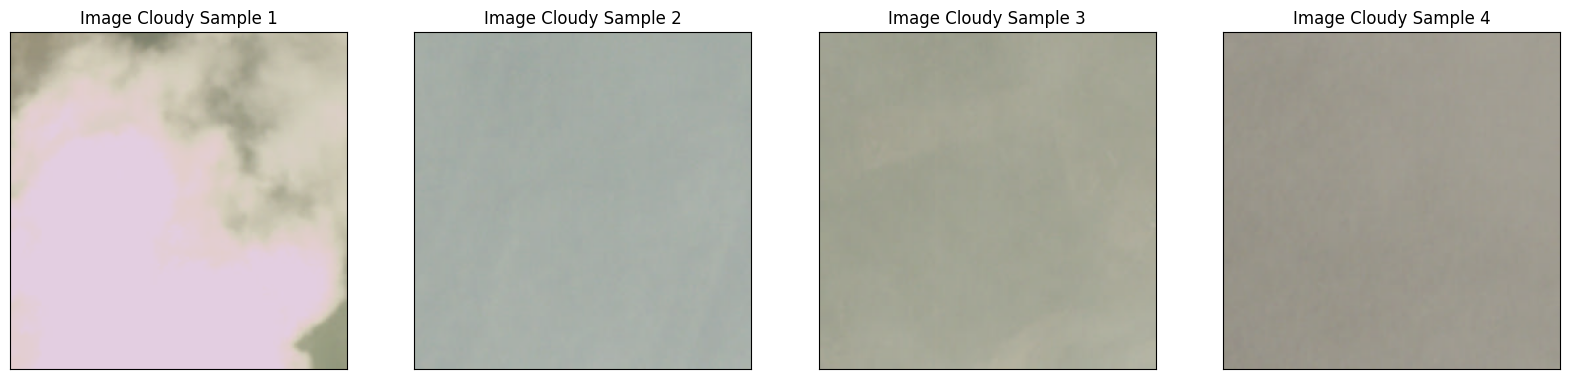

In [7]:
sampleImage('data/cloudy', 'Cloudy')

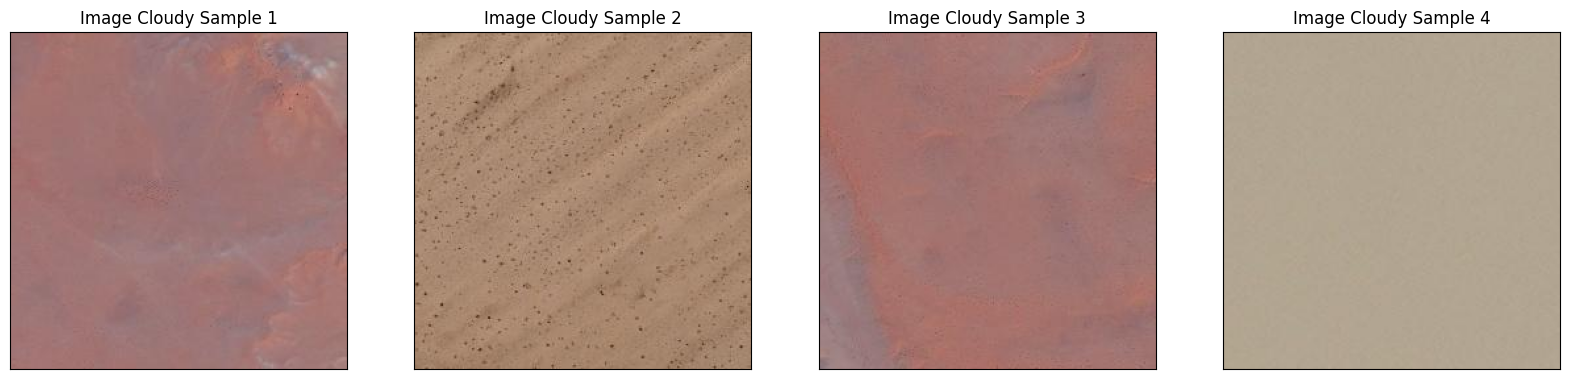

In [8]:
sampleImage('data/desert', 'Cloudy')

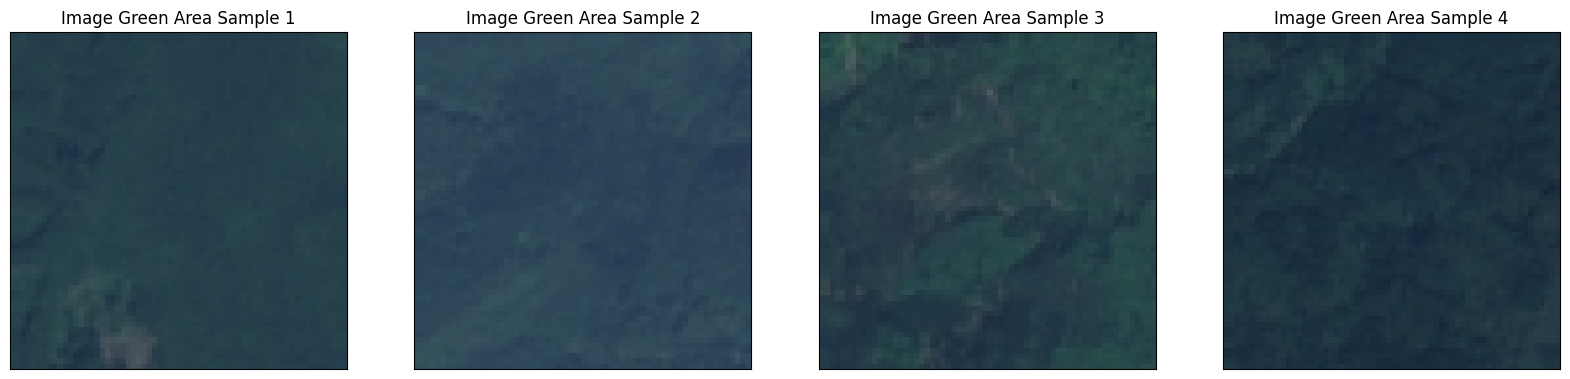

In [9]:
sampleImage('data/green_area', 'Green Area')

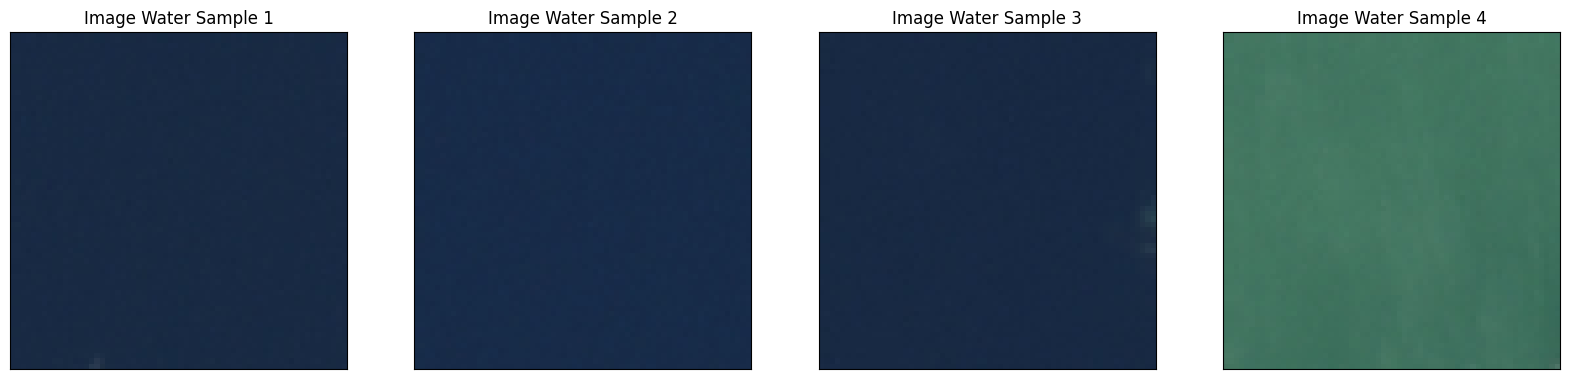

In [10]:
sampleImage('data/water', 'Water')

## Applying Gaussian Blur

In [11]:
def applyGaussianBlur(folder_path):
    base_path = 'satellite-image/data/'
    apply_path = base_path + folder_path
    save_path = f'satellite-image/gaussianBlur/{folder_path}'
    os.makedirs(save_path, exist_ok=True)
    
    for i in os.listdir(apply_path):
        image = cv2.imread(f'{apply_path}/{i}')
        blurred_img = cv2.GaussianBlur(image, (3, 3), 0)
        cv2.imwrite(f'{save_path}/{i}', blurred_img)

In [12]:
for i in os.listdir('satellite-image/data/'):
    applyGaussianBlur(i)

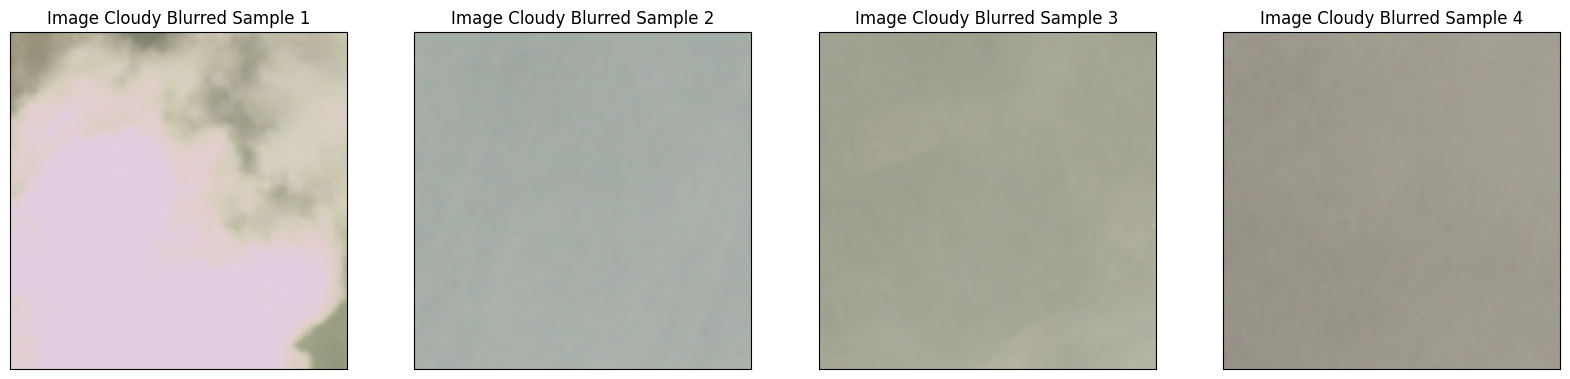

In [13]:
sampleImage('gaussianBlur/cloudy', 'Cloudy Blurred')

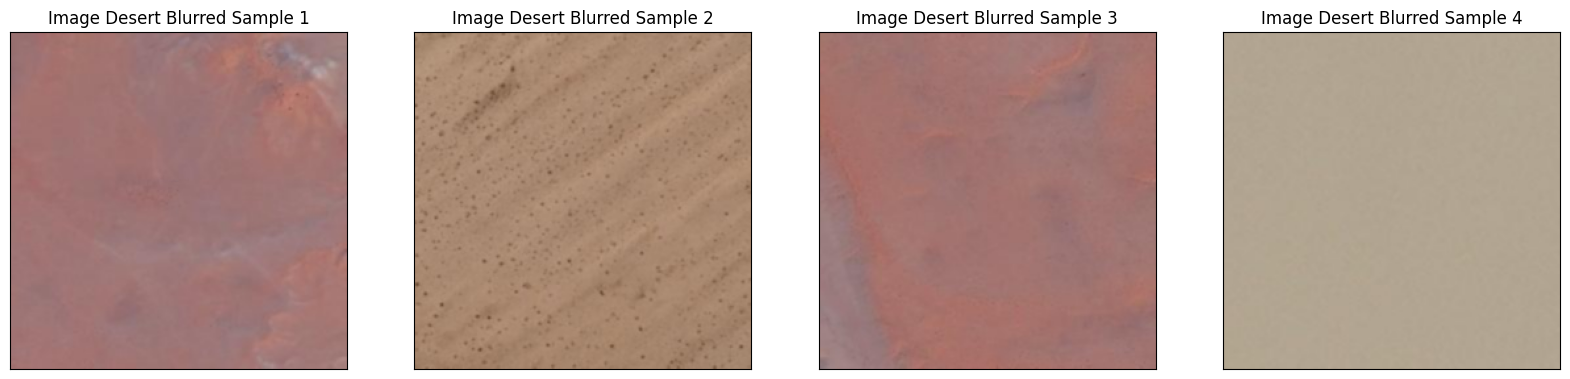

In [14]:
sampleImage('gaussianBlur/desert', 'Desert Blurred')

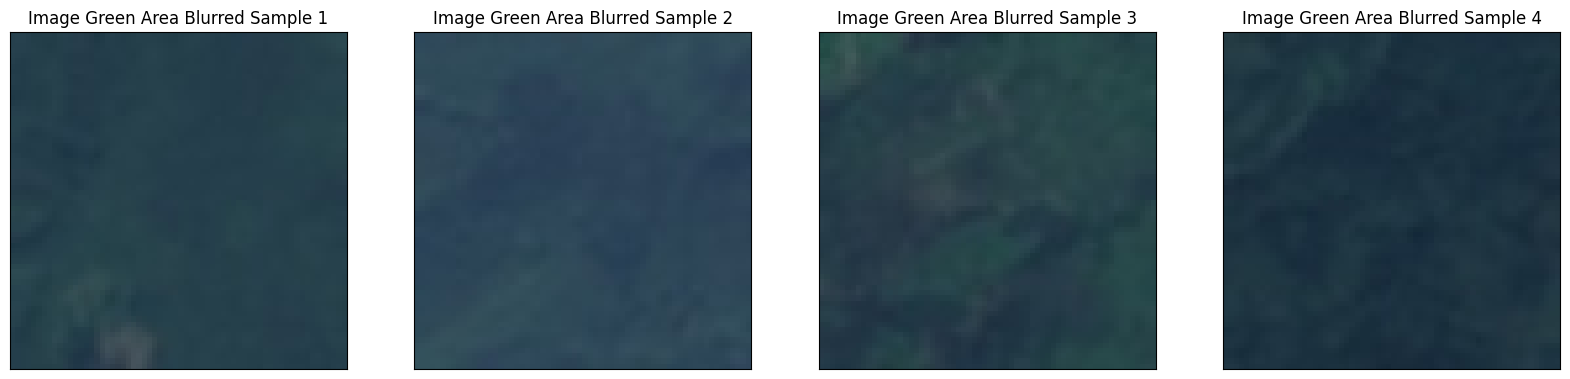

In [15]:
sampleImage('gaussianBlur/green_area', 'Green Area Blurred')

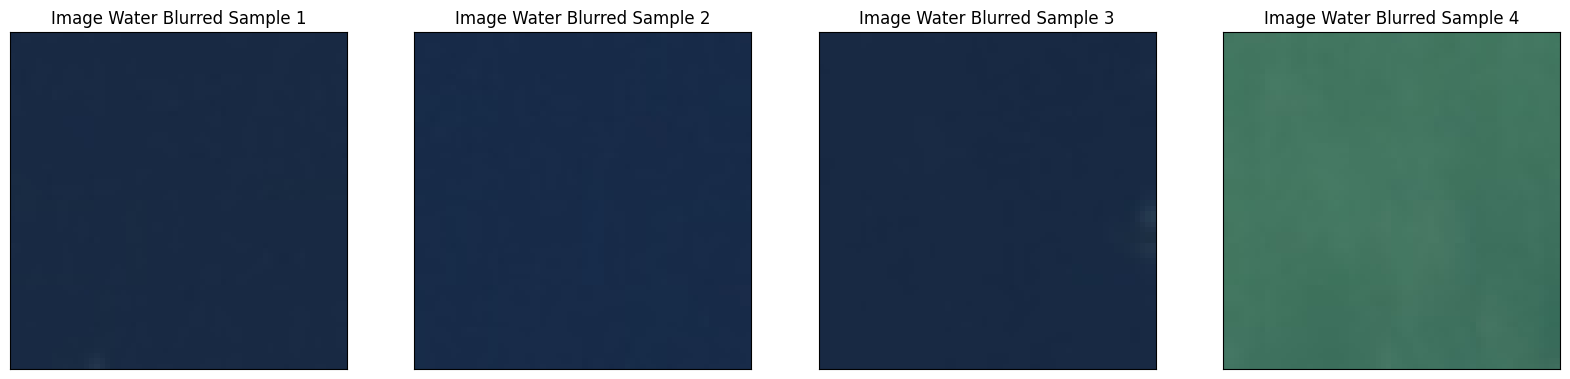

In [16]:
sampleImage('gaussianBlur/water', 'Water Blurred')

## Applying Local Binary Patterns

In [17]:
def applyLBPImage(folder_path):
    base_path = 'satellite-image/gaussianBlur/'
    apply_path = base_path + folder_path
    save_path = f'satellite-image/lbpImage/{folder_path}'
    os.makedirs(save_path, exist_ok=True)
    
    radius = 3
    n_points = 8*radius
    
    for i in os.listdir(apply_path):
        image = cv2.imread(f'{apply_path}/{i}', 0)
        lbp_img = local_binary_pattern(image, n_points, radius, 'uniform')
        cv2.imwrite(f'{save_path}/{i}', lbp_img)

In [18]:
for i in os.listdir('satellite-image/data/'):
    applyLBPImage(i)

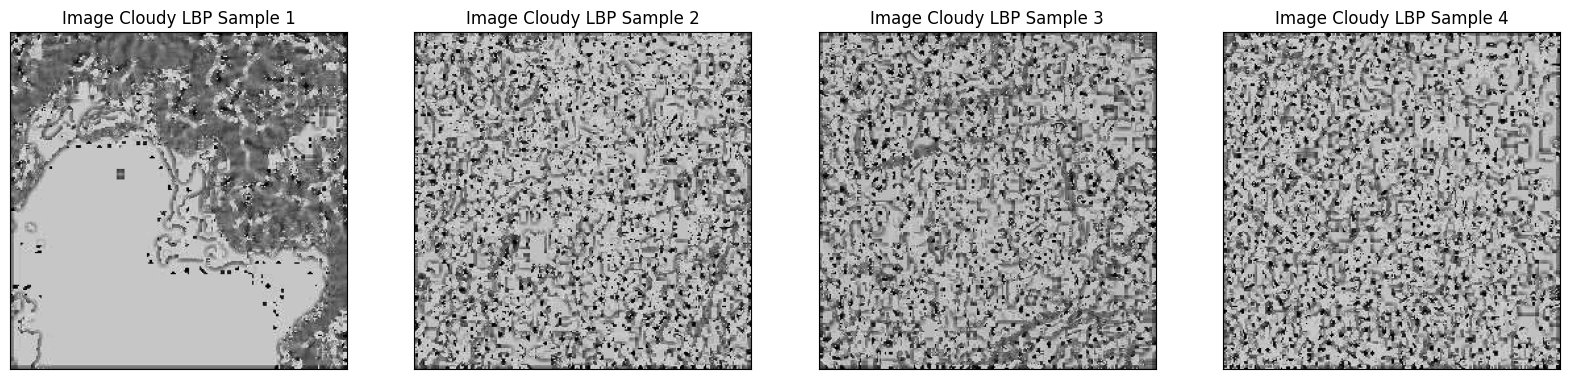

In [19]:
sampleImage('lbpImage/cloudy', 'Cloudy LBP', gray=True)

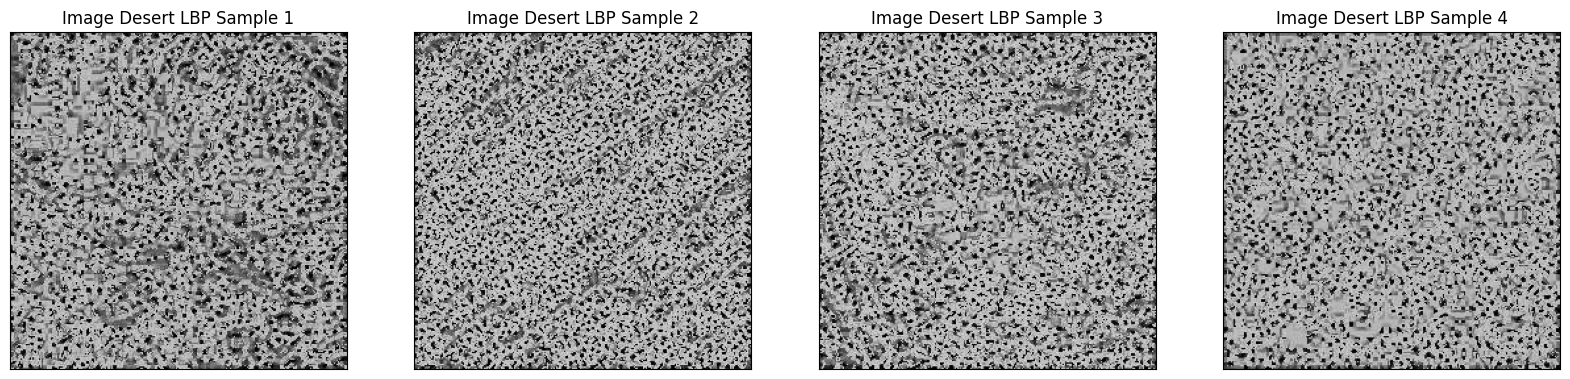

In [20]:
sampleImage('lbpImage/desert', 'Desert LBP', gray=True)

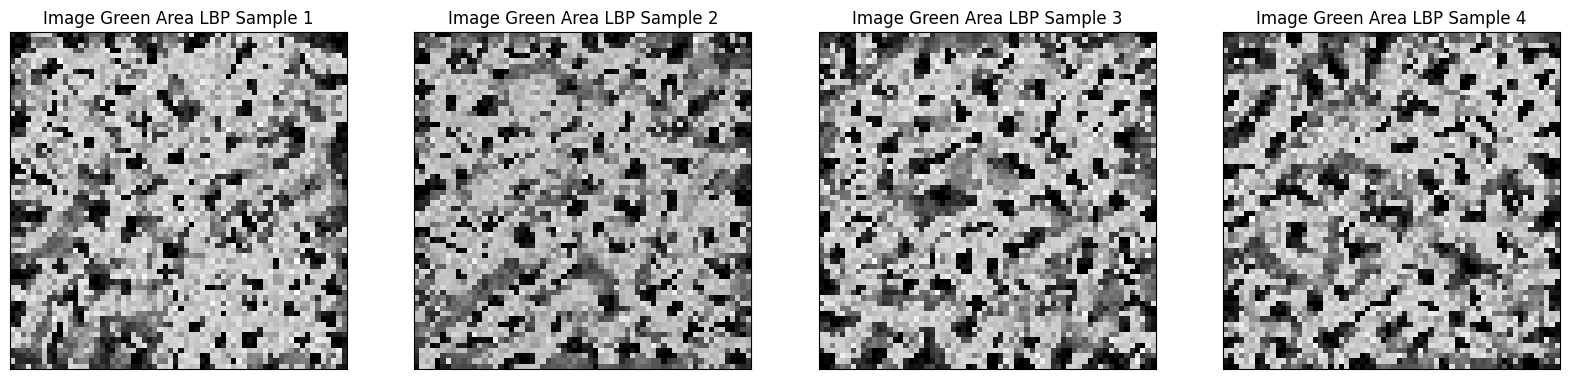

In [21]:
sampleImage('lbpImage/green_area', 'Green Area LBP', gray=True)

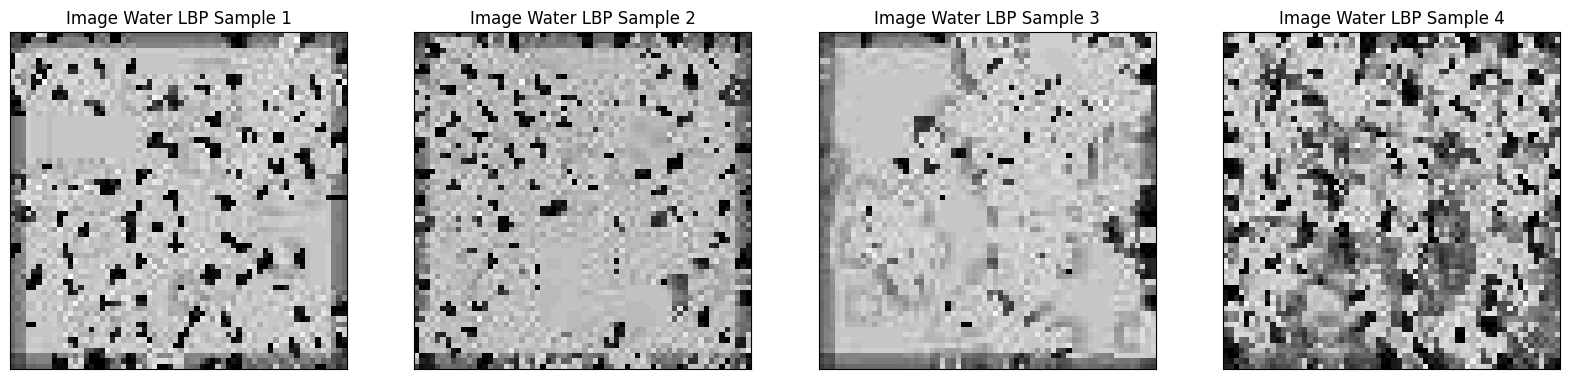

In [22]:
sampleImage('lbpImage/water', 'Water LBP', gray=True)

## Build CNN Model

In [23]:
train_dir = os.path.join(os.getcwd(), 'satellite-image', 'lbpImage')

In [24]:
train_datagen = ImageDataGenerator(
	rescale=1./255,
    rotation_range=20,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    vertical_flip=True,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

In [25]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(100, 100),
    batch_size=16,
    color_mode='grayscale',
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (100, 100),
    batch_size=16,
    color_mode='grayscale',
    class_mode='categorical',
    subset='validation'
)

Found 4505 images belonging to 4 classes.
Found 1126 images belonging to 4 classes.


In [26]:
from keras.regularizers import l2

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.01), input_shape=(100, 100, 1)),
    MaxPooling2D(2, 2),
    Dropout(0.1),
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    MaxPooling2D(2, 2),
    Dropout(0.1),
    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    MaxPooling2D(2, 2),
    Dropout(0.1),
    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dense(4, activation='softmax')
])

c:\Users\nicol\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [27]:
model.compile(loss='categorical_crossentropy',
            optimizer=tf.optimizers.Adam(learning_rate=0.001),
            metrics=['accuracy'])

In [28]:
from keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

model.fit(
    train_generator,
    steps_per_epoch=25,
    epochs=50,
    shuffle=True,
    validation_data=validation_generator,
    validation_steps=3,
    verbose=2,
    callbacks=[reduce_lr]
)

Epoch 1/50


c:\Users\nicol\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


25/25 - 7s - 260ms/step - accuracy: 0.7000 - loss: 1.7974 - val_accuracy: 0.4375 - val_loss: 2.4930 - learning_rate: 0.0010
Epoch 2/50
25/25 - 3s - 129ms/step - accuracy: 0.8325 - loss: 1.1810 - val_accuracy: 0.2083 - val_loss: 2.1355 - learning_rate: 0.0010
Epoch 3/50
25/25 - 3s - 118ms/step - accuracy: 0.8500 - loss: 0.9556 - val_accuracy: 0.3958 - val_loss: 1.7194 - learning_rate: 0.0010
Epoch 4/50
25/25 - 3s - 117ms/step - accuracy: 0.8800 - loss: 0.7739 - val_accuracy: 0.2500 - val_loss: 1.9902 - learning_rate: 0.0010
Epoch 5/50
25/25 - 3s - 106ms/step - accuracy: 0.8375 - loss: 0.7938 - val_accuracy: 0.6667 - val_loss: 1.3514 - learning_rate: 0.0010
Epoch 6/50
25/25 - 3s - 101ms/step - accuracy: 0.8775 - loss: 0.6470 - val_accuracy: 0.6667 - val_loss: 1.2150 - learning_rate: 0.0010
Epoch 7/50
25/25 - 3s - 103ms/step - accuracy: 0.8475 - loss: 0.6407 - val_accuracy: 0.5208 - val_loss: 1.3533 - learning_rate: 0.0010
Epoch 8/50
25/25 - 2s - 90ms/step - accuracy: 0.8175 - loss: 0.665

c:\Users\nicol\AppData\Local\Programs\Python\Python311\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


25/25 - 3s - 104ms/step - accuracy: 0.8900 - loss: 0.4396 - val_accuracy: 0.6667 - val_loss: 0.9565 - learning_rate: 0.0010
Epoch 14/50
25/25 - 2s - 81ms/step - accuracy: 0.8625 - loss: 0.4700 - val_accuracy: 0.6042 - val_loss: 1.0362 - learning_rate: 0.0010
Epoch 15/50
25/25 - 2s - 76ms/step - accuracy: 0.8700 - loss: 0.4514 - val_accuracy: 0.2292 - val_loss: 2.1355 - learning_rate: 0.0010
Epoch 16/50
25/25 - 2s - 78ms/step - accuracy: 0.8575 - loss: 0.4765 - val_accuracy: 0.5000 - val_loss: 1.1243 - learning_rate: 0.0010
Epoch 17/50
25/25 - 2s - 77ms/step - accuracy: 0.8500 - loss: 0.4396 - val_accuracy: 0.4583 - val_loss: 1.8479 - learning_rate: 5.0000e-04
Epoch 18/50
25/25 - 2s - 72ms/step - accuracy: 0.8925 - loss: 0.3855 - val_accuracy: 0.7708 - val_loss: 0.6676 - learning_rate: 5.0000e-04
Epoch 19/50
25/25 - 2s - 72ms/step - accuracy: 0.8875 - loss: 0.3933 - val_accuracy: 0.5833 - val_loss: 0.7600 - learning_rate: 5.0000e-04
Epoch 20/50
25/25 - 2s - 73ms/step - accuracy: 0.8880 

## Evaluate

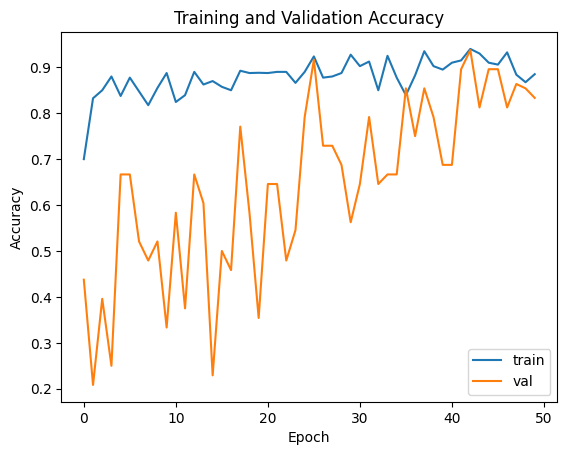

In [29]:
plt.plot(model.history.history['accuracy'], label='Train Accuracy')
plt.plot(model.history.history['val_accuracy'], label='Validation Accuracy')

plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'])

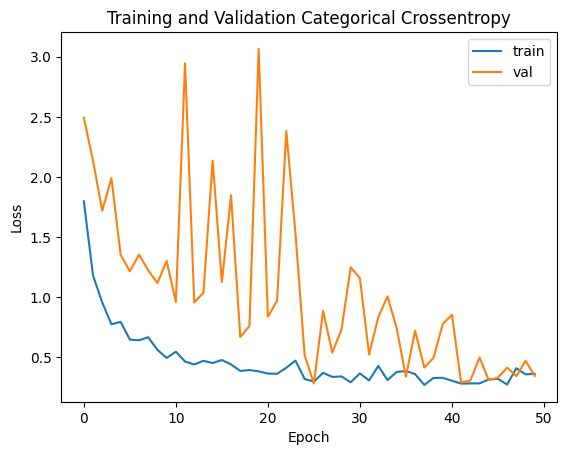

In [30]:
plt.plot(model.history.history['loss'], label='Train Loss')
plt.plot(model.history.history['val_loss'], label='Validation Loss')

plt.title('Training and Validation Categorical Crossentropy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


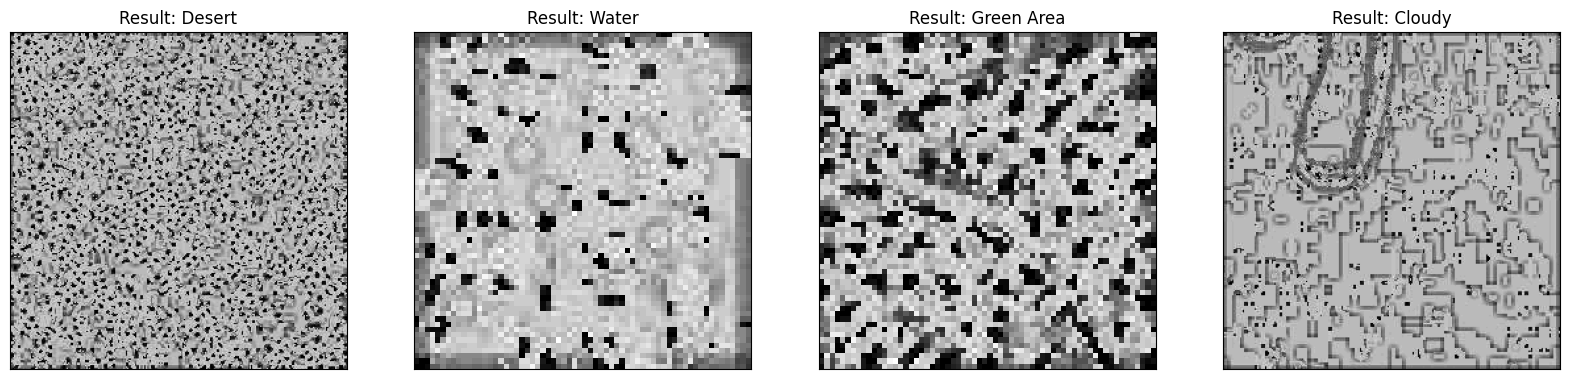

In [40]:
base_path = 'satellite-image/lbpImage'
testImage = {f'{base_path}/cloudy', f'{base_path}/desert', f'{base_path}/green_area', f'{base_path}/water'}

plt.figure(figsize=(20, 15))

for i, path in enumerate(testImage, start=1):
    listImage = os.listdir(path)

    if listImage:
        img_path = f'{path}/{listImage[6]}'
        img = cv2.imread(img_path, 0) 
        img_resized = cv2.resize(img, (100, 100))
        img_norm = img_resized / 255.0

        img_final = img_norm.reshape(1, 100, 100, 1)
        
        classes = model.predict(img_final)
        
        index = np.argmax(classes)
        
        class_names = ['Cloudy', 'Desert', 'Green Area', 'Water']
        predict = class_names[index]

        plt.subplot(1, 4, i)
        plt.imshow(img, cmap='gray')
        plt.title(f'Result: {predict}')
        plt.xticks([])
        plt.yticks([])

## Save Model

In [32]:
model.save('model_satellite.h5')